In [1]:
println("Hello super people!")

Hello super people!


In [29]:
using Random, Plots, Statistics, Combinatorics, LaTeXStrings, CSV, DataFrames
gr()

Plots.GRBackend()

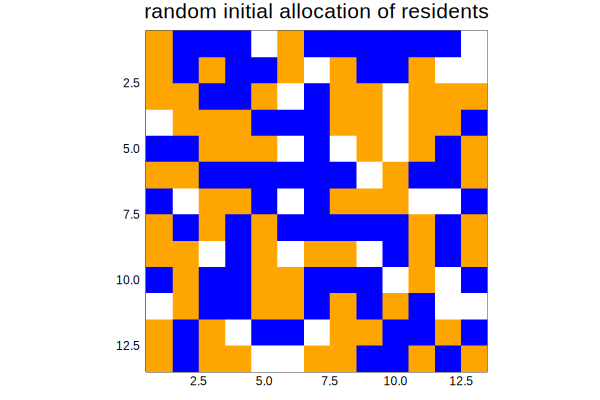

In [3]:

#define the grid
#schelling used originally 13x13 grid
GRID_SIZE = 13
CELL_COUNT = GRID_SIZE^2

THRESHOLD_SAME = 4
THRESHOLD_EDGE = 3
THRESHOLD_CORNER = 2

PP = 5

MM = 10#number of simulations
TT = 25#number of time points in simulation


yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
empty_count = CELL_COUNT - yellow_count - blue_count

#the total number of possible configurations
CELLS_SPACE_SIZE = multinomial(BigInt(yellow_count),BigInt(blue_count),BigInt(empty_count))
#println(CELLS_SPACE_SIZE)

#boltzmann constant
k_b = 1.380649*10^-23


empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

start_grid = shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h = heatmap(start_grid,title="random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


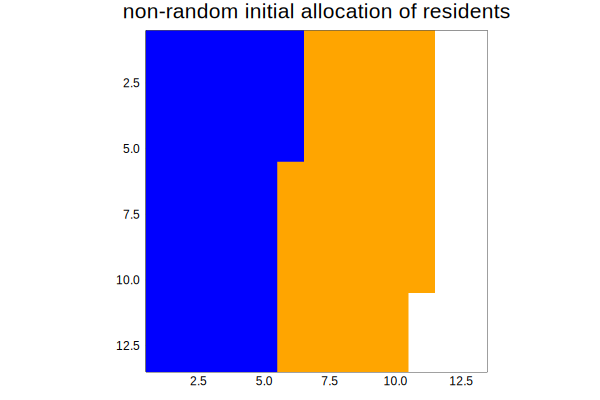

In [4]:
savefig(h,"figs/randomAllocationInit.png")

yellow_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))
blue_count = Int(round(CELL_COUNT * PP/(GRID_SIZE-1)))

empty_grid = zeros(GRID_SIZE,GRID_SIZE)
empty_grid[1:yellow_count] .= 1
empty_grid[yellow_count+1:yellow_count+blue_count] .= -1

set_grid = empty_grid#shuffle(empty_grid)

#random initial allocation heatmap viz
#yellow = -1, blue = 1
h2 = heatmap(set_grid,title="non-random initial allocation of residents",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))

In [5]:
savefig(h2,"figs/setAllocation.png")

#macrostate function mapping (eg, what is the total satisfaction of the residents overall the cells, total sum from zero to max)
#function overall_satisfaction(start_grid)

function grid_satisfaction(grid)
    cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            
            t=cell_surround_arrayTMP(grid,row,col)  #R2 = R_grid(start_grid)
            tmpBinary = thresholdFN(t,grid[row,col],row,col)
            append!(cell_satisfaction,tmpBinary)
        end
    end
    return sum(cell_satisfaction)
end

function thresholdFN(cellSurroundArray,cellType,row,col)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end
function cell_surround_arrayTMP(grid,row,col)
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end

    return cell_surrounding
end

R_MAX = grid_satisfaction(set_grid)
println("set grid satisfaction value MAX=",R_MAX)
R_START = grid_satisfaction(start_grid)
println("set grid satisfaction value START=",R_START)


set grid satisfaction value MAX=140
set grid satisfaction value START=48


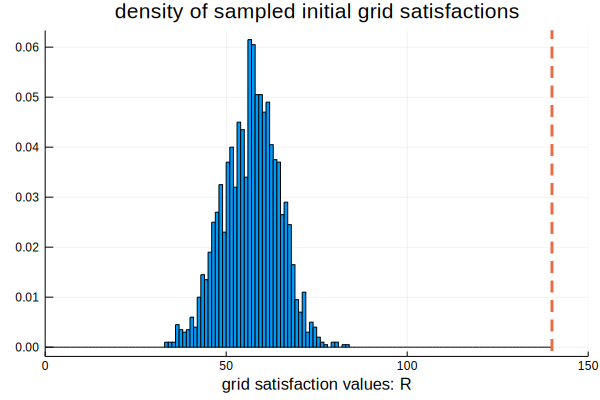

In [6]:
#sample the random intializations and investigate 
function make_random_grid()
    empty_grid = zeros(GRID_SIZE,GRID_SIZE)
    empty_grid[1:yellow_count] .= 1
    empty_grid[yellow_count+1:yellow_count+blue_count] .= -1
    random_grid = shuffle(empty_grid)
    return random_grid
end
numberOfRandomSamples = 2000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]
normedRandomSatisfactions = randomSatisfactions ./ sum(randomSatisfactions)
pltHist = histogram(randomSatisfactions,bins=0:1:R_MAX,normalize=:probability,xlim=(0,R_MAX+10),title="density of sampled initial grid satisfactions",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

In [7]:
savefig(pltHist,"figs/histogramOfSampledInitSatisfactions.png")

#llok at not the grid level satisfaction but the single cell level satisfaction
function cell_surround_array(grid,row,col)
    #if((row==1 && col==1))#top left corner
    cell_surrounding = []
    for ii in 0:2
        for jj in 0:2
            if(!(  (ii==1 && jj==1) || (row-1+(ii) < 1) ||  (col-1+(jj) < 1) || (row-1+(ii) > GRID_SIZE) || (col-1+(jj) > GRID_SIZE)   ))
                append!(cell_surrounding,grid[row-1+(ii),(col-1)+(jj)])
            end

        end
    end
  
    return cell_surrounding
end

function is_cell_satisfied(grid,row,col)
    cellSurroundArray = cell_surround_array(grid,row,col)
    #println(cellSurroundArray)
    cellType = grid[row,col]
    #println(cellType)
    homogeneity = length(findall(cellType .== cellSurroundArray))
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = is_cell_satisfied(start_grid,8,7)
#println(cell_satisfied)
 


is_cell_satisfied (generic function with 1 method)

In [8]:
#testing for if a cell would be satisfied if it were placed there
function would_cell_be_satisfied(grid,row,col,cellType)
    cellSurroundArray = cell_surround_array(grid,row,col)    
    #println(cellSurroundArray)
    homogeneity = length(findall(cellType .== cellSurroundArray))    
    #println(homogeneity)
    if(cellType != 0)
        if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
            return homogeneity >= THRESHOLD_SAME ? 1 : 0
        elseif((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0    
        elseif((row==1 && col==1))#top left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && col==GRID_SIZE))#top right corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==GRID_SIZE && col==1))#bottom left corner
            return homogeneity >= THRESHOLD_CORNER ? 1 : 0
        elseif((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        elseif( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
            return homogeneity >= THRESHOLD_EDGE ? 1 : 0
        end
    else
        return 0
    end
end 

#cell_satisfied = would_cell_be_satisfied(start_grid,7,9,start_grid[2,2])
#println(cell_satisfied)
 

would_cell_be_satisfied (generic function with 1 method)

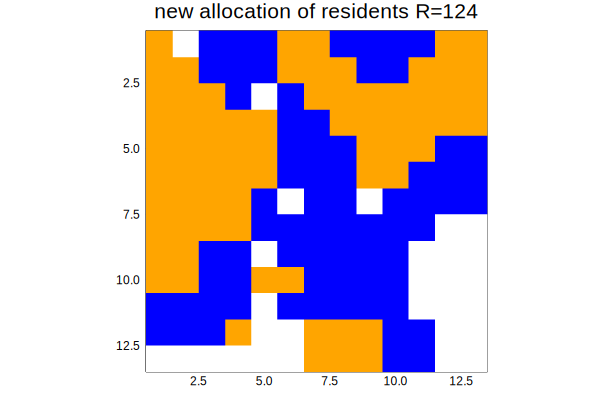

In [9]:
#get non-empty cell set
#Search for an unsatisfied iteratively in all the cells through a shuffled list
#find all empty cells
#shuffle the list of the empty cells
#see if the cell would_cell_be_satisfied in any of the cells in sequence
#no, move on to the next cell
#if yes, change the original cell position to empty and make the new cell the cell type
#loop till all non-empty cells are tested

function move_cells_for_satisfaction(grid)
    
    newGrid = deepcopy(grid)
    nonZeroCells = findall(grid .!= 0)
    nonZeroCells2 = shuffle(nonZeroCells)
    satisfiedNonZeroCells = [is_cell_satisfied(newGrid,nzc[1],nzc[2]) for nzc in nonZeroCells2]    
    #R_START = grid_satisfaction(grid)

    #remove (skip) the satisfied, don't include them in the rotation on each iteration
    satisfiedInds = findall(satisfiedNonZeroCells .== 1)
    deleteat!(nonZeroCells2,satisfiedInds)   
    
    for nzc in nonZeroCells2        
        isCellSatisfied = is_cell_satisfied(newGrid,nzc[1],nzc[2])
        
        if(isCellSatisfied != 1)          
            emptyCells = findall(newGrid .== 0)
            emptyCells2 = shuffle(emptyCells)
            #find an empty cell nzc could move to
            moved = false
            for ec in emptyCells2                
                wouldCellBeSatisfied = would_cell_be_satisfied(newGrid,ec[1],ec[2],newGrid[nzc[1],nzc[2]] )
                if(wouldCellBeSatisfied == 1)  
                    
                    newGrid[ec[1],ec[2]] = newGrid[nzc[1],nzc[2]]
                    newGrid[nzc[1],nzc[2]] = 0  
                    #no longer try to move it
                    moved = true
                    break
                end                
            end   
            #=if(moved == false)
                println("cell at i=$(nzc[1]) and j=$(nzc[2]) did not move")
            end=#
        end       
    end
    
    return newGrid
end

newGrid = move_cells_for_satisfaction(start_grid)

satisfiedOneGrid = grid_satisfaction(newGrid)
#println(satisfiedOneGrid)
h3 = heatmap(newGrid,title="new allocation of residents R=$(satisfiedOneGrid)",
    showaxis=true,xticks=true,yticks=true,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))


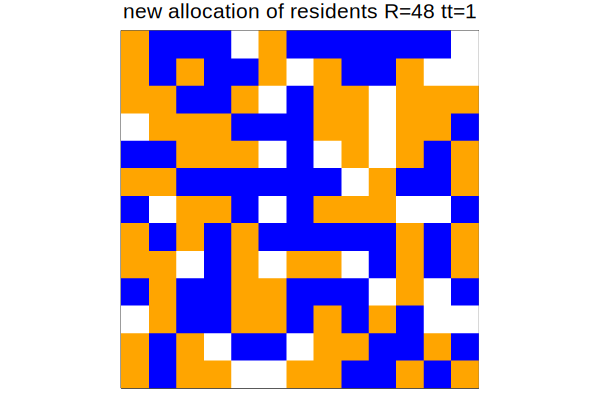

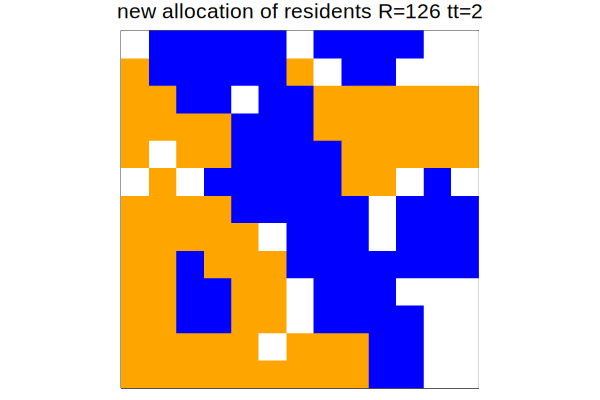

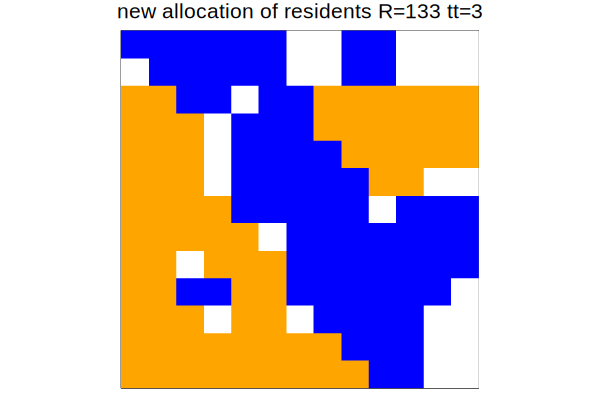

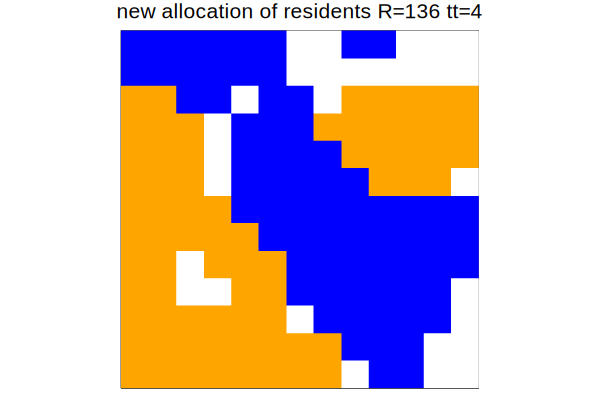

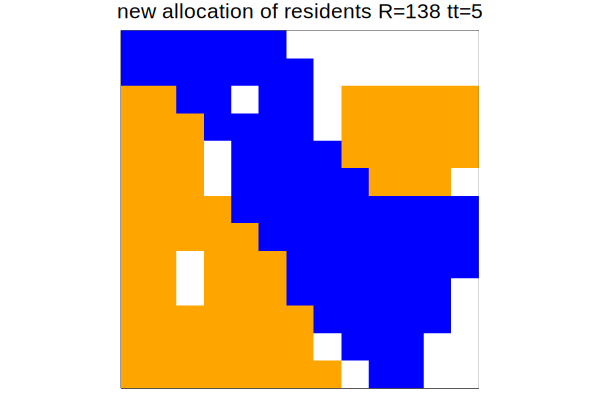

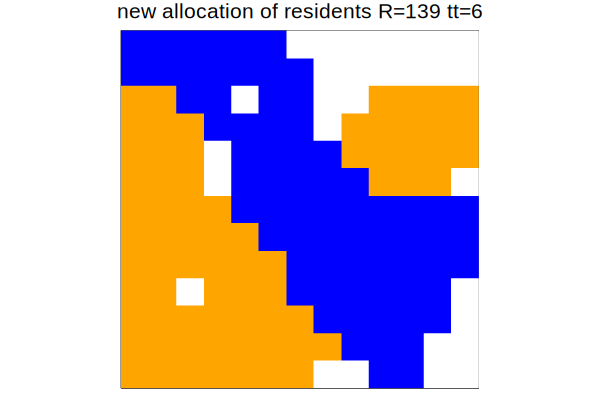

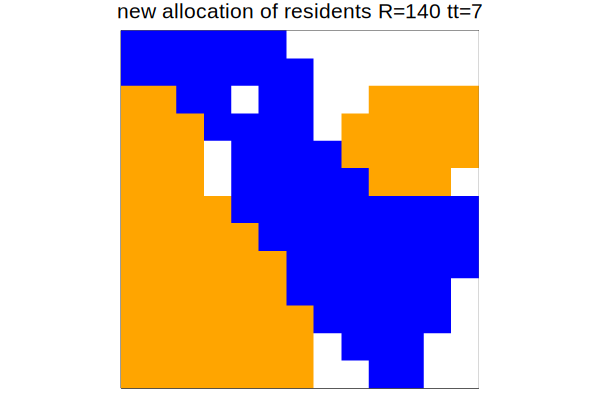

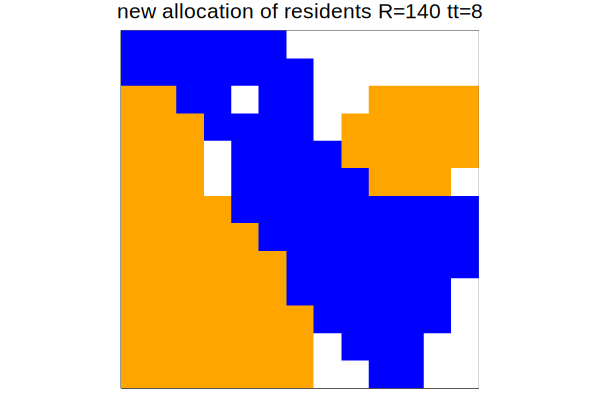

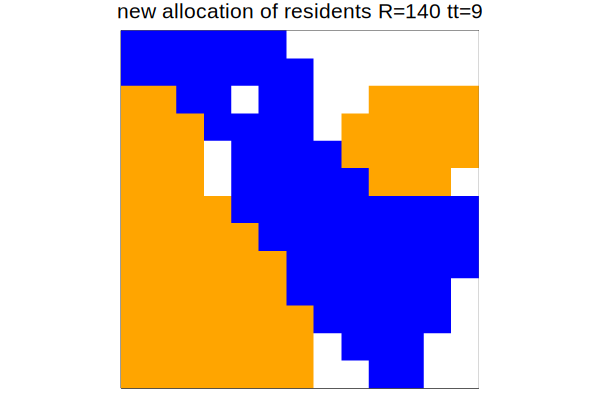

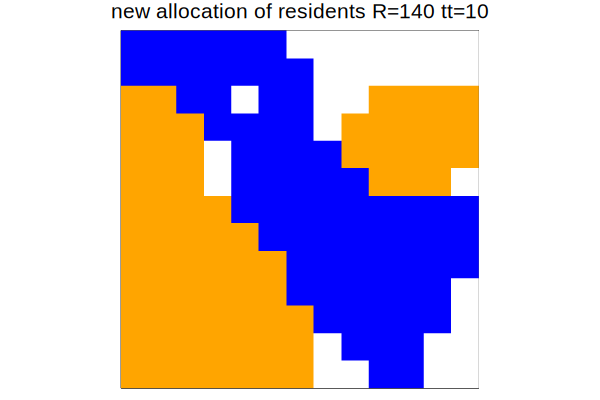

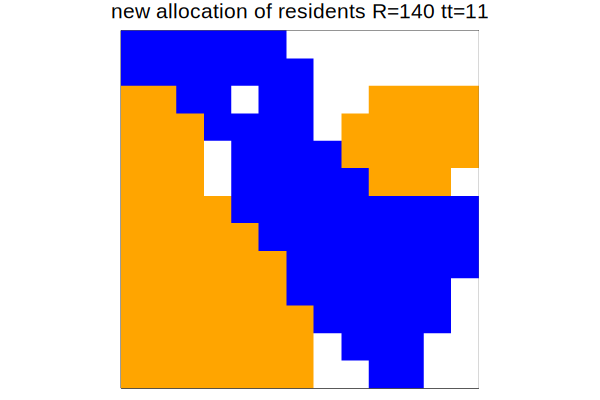

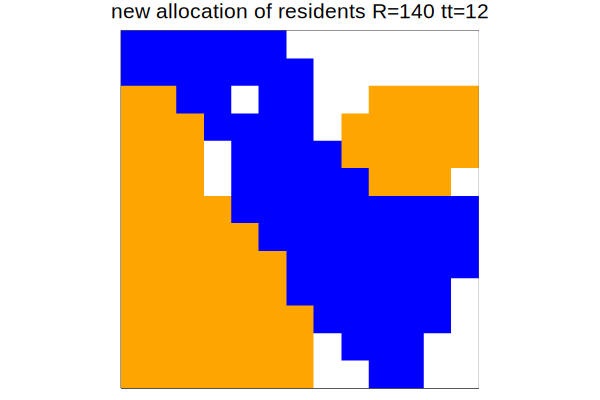

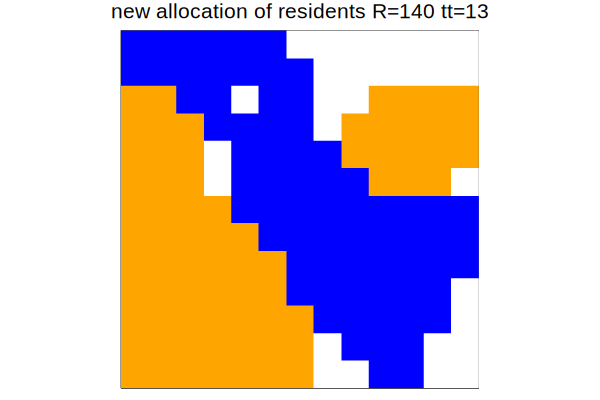

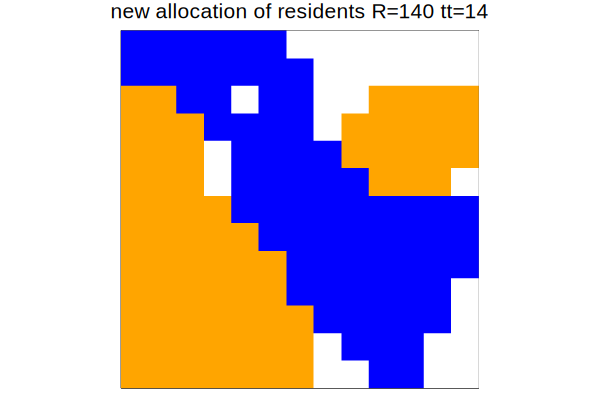

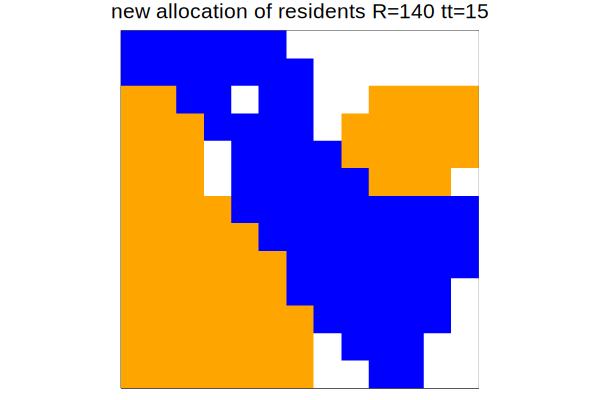

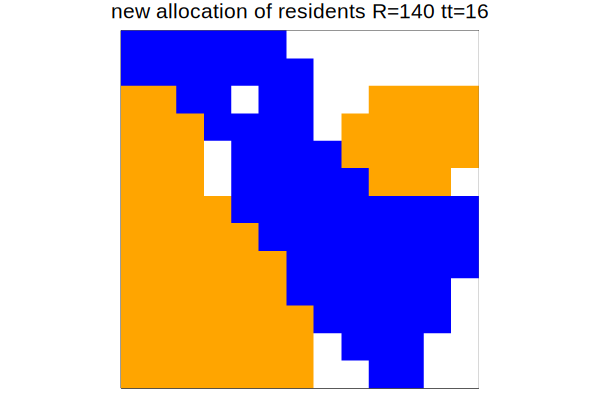

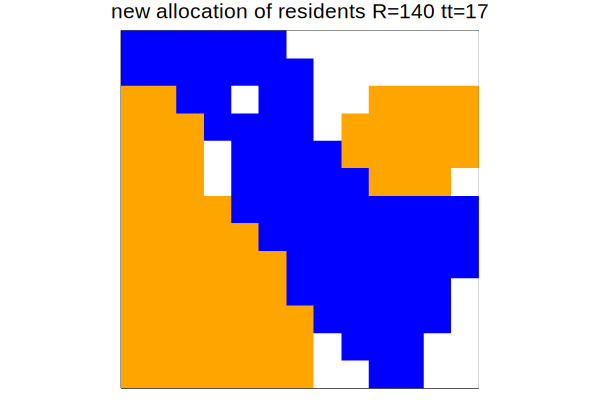

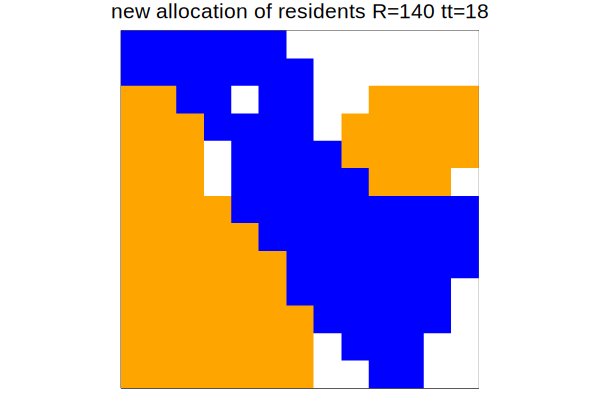

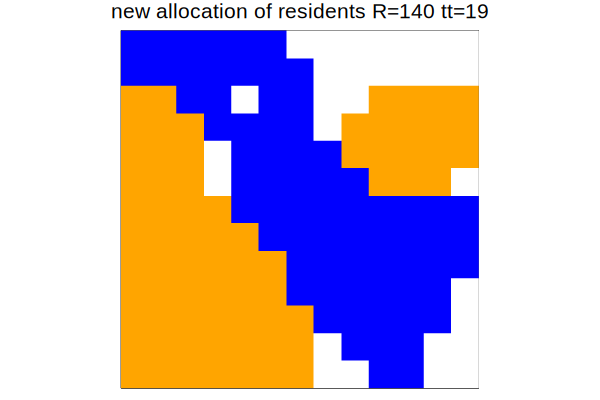

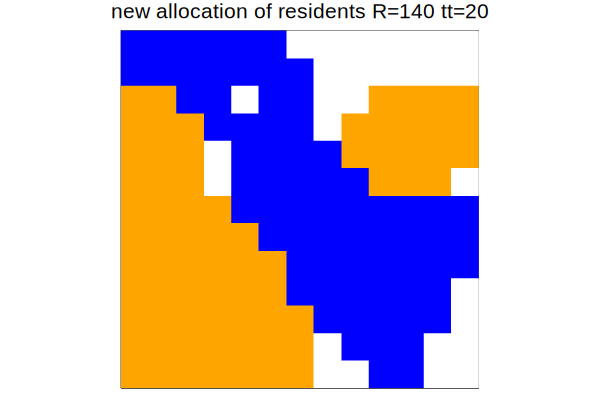

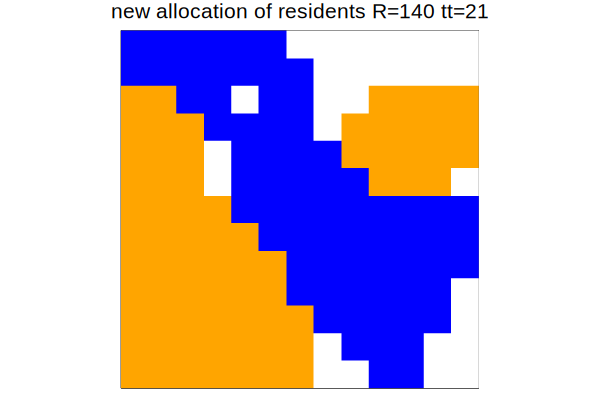

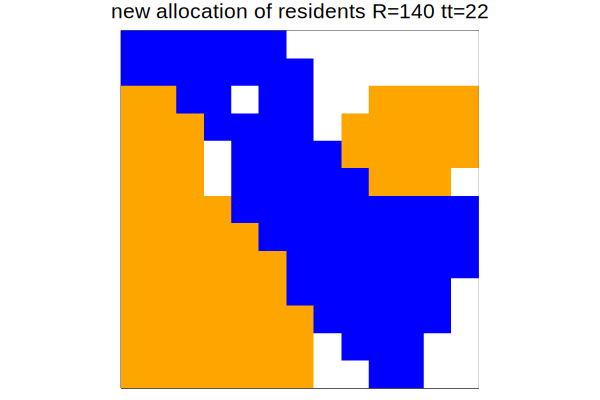

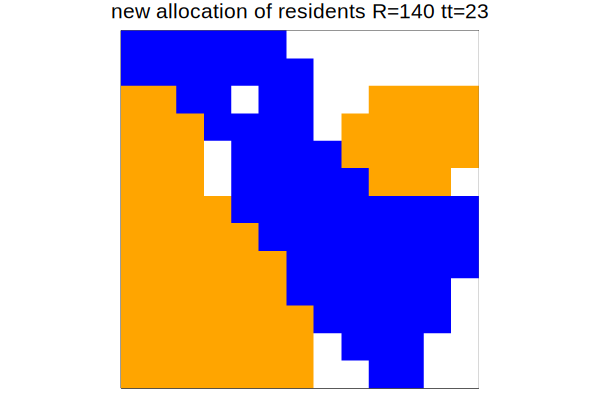

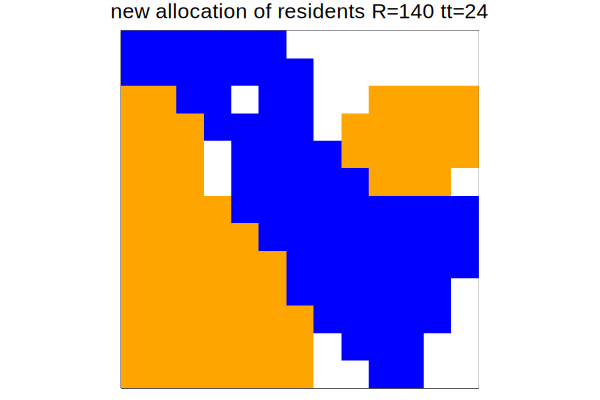

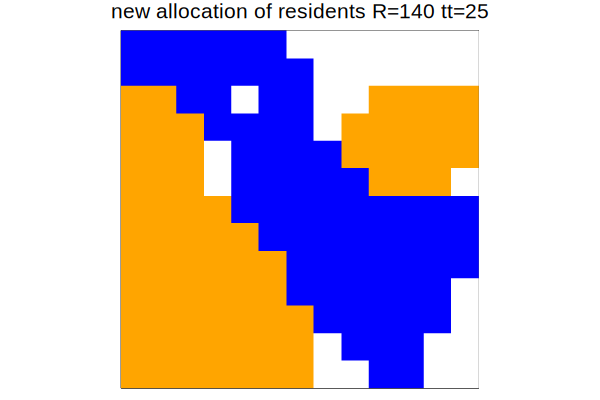

In [10]:
savefig(h3,"figs/newAllocation.png")


gridDict = Dict()
gridDict[1] = start_grid

for tt in 2:TT
gridDict[tt] = move_cells_for_satisfaction(gridDict[tt-1])
end
#println(gridDict)

hArray = []

for tt in 1:TT
    #println("tt=$tt")
    R = grid_satisfaction(gridDict[tt])
    hm = heatmap(gridDict[tt],title="new allocation of residents R=$(R) tt=$tt",
    showaxis=true,xticks=false,yticks=false,yaxis=:flip,aspect_ratio=1.0,framestyle=:box,xlims=(0.5,GRID_SIZE+0.5),legend=nothing,
    c=ColorGradient([:orange,:white,:blue]))
    display(hm)
    savefig(hm,"figs/simulationSnapShots1/time$(tt).png")
end



[48, 126, 133, 136, 138, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Array{Int64,1}


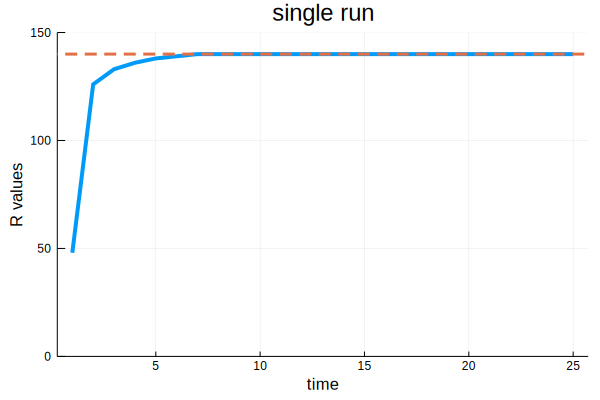

In [11]:

traceR = Int[]

for tt in 1:TT    
    append!(traceR,grid_satisfaction(gridDict[tt]))    
end
println(traceR)
println(typeof(traceR))
plt = plot(traceR,ylim=(0,R_MAX+10),leg=false,linewidth=4,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")

#plot(traceR,ylim=(0,R_MAX+10),leg=false,guidefont=14,linewidth=4,xtickfontsize=10,ytickfontsize=10,titlefontsize=16,title="single run",xlabel="time",ylabel="R values")
hline!([R_MAX],line=(3,:dash),leg=false)

(25, 10)
[55.9; 127.3; 134.7; 137.6; 138.2; 138.6; 138.7; 138.4; 139.0; 139.1; 139.2; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3; 139.3]


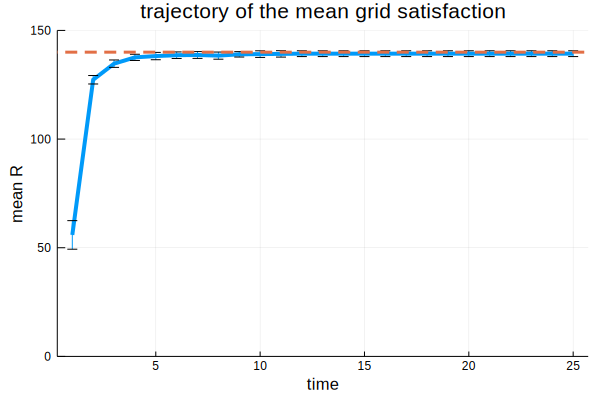

In [12]:
savefig(plt,"figs/singleRun.png")


simulationRvals = zeros(TT,MM)
for mm in 1:MM
    newGrid = shuffle(empty_grid)
    traceR = []
    append!(traceR,grid_satisfaction(newGrid))#initial time zero point
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        append!(traceR,grid_satisfaction(newGrid))
    end
    simulationRvals[:,mm] = traceR[:]

end
    

println(size(simulationRvals))
println(mean(simulationRvals,dims=2))
plt = plot(mean(simulationRvals,dims=2),xlabel="time",ylabel="mean R",yerr=std(simulationRvals,dims=2),linewidth=4,ylim=(0,R_MAX+10),title="trajectory of the mean grid satisfaction") 
hline!([R_MAX],line=(3,:dash),leg=false)

In [13]:
savefig(plt,"figs/multipleRun.png")


println(simulationRvals[end,:])

[140.0, 140.0, 140.0, 140.0, 140.0, 136.0, 140.0, 140.0, 138.0, 139.0]


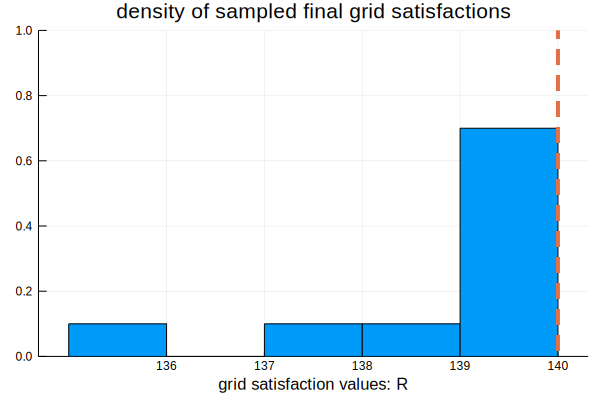

In [14]:
#get the histogram of the final values

pltHist = histogram(simulationRvals[end,:] .- 1,ylim=(0,1.0),xticks = (minimum(simulationRvals[end,:]):maximum(simulationRvals[end,:])) ,normalize=:probability,title="density of sampled final grid satisfactions",xlabel="grid satisfaction values: R",leg=false)#,xlim=(0,R_MAX+10)
vline!([R_MAX],line=(4,:dash),leg=false)



In [15]:
savefig(pltHist,"figs/finalHistRvals.png")


#sample random microstates
numberOfRandomSamples = 15000
randomSatisfactions = [grid_satisfaction(make_random_grid()) for x in 1:numberOfRandomSamples]

#set the macrostate count array to those random allocations 
sampleCountsR = [length(findall(randomSatisfactions .== R)) for R in 1:R_MAX]
#println(sampleCountsR)
replace!(sampleCountsR,0=>1)
#println(sampleCountsR)
sampleProbR = sampleCountsR ./ sum(sampleCountsR)
#println(sampleProbR)
#println(sum(sampleProbR))

#The cellspace for the macrostates is the multiple of the probability
sampleOmegaR = sampleProbR .* CELLS_SPACE_SIZE
#println(sampleOmegaR)


println(sampleOmegaR)
println(size(sampleOmegaR))

BigFloat[2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 2.23143e+69, 8.92571e+69, 2.23143e+69, 2.23143e+69, 2.00829e+70, 1.78514e+70, 2.45457e+70, 2.90086e+70, 3.79343e+70, 7.36371e+70, 9.14885e+70, 1.33886e+71, 1.78514e+71, 2.40994e+71, 2.63308e+71, 4.0612e+71, 4.77526e+71, 6.15874e+71, 6.69428e+71, 8.56868e+71, 9.79597e+71, 1.1358e+72, 1.18935e+72, 1.31654e+72, 1.52853e+72, 1.56423e+72, 1.62002e+72, 1.67357e+72, 1.62002e+72, 1.61109e+72, 1.74275e+72, 1.67357e+72, 1.52853e+72, 1.51291e+72, 1.29869e+72, 1.30539e+72, 1.01307e+72, 8.70257e+71, 7.85463e+71, 7.3414e+71, 6.00254e+71, 4.81988e+71, 3.21326e+71, 3.124e+71, 2.38763e+71, 2.07523e+71, 1.27191e+71, 9.14885e+70, 7.81e+70, 5.80171e+70

BigFloat[2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.22377e-21, 2.20463e-21, 2.20463e-21, 2.23497e-21, 2.23334e-21, 2.23774e-21, 2.24005e-21, 2.24375e-21, 2.25291e-21, 2.25591e-21, 2.26116e-21, 2.26513e-21, 2.26928e-21, 2.2705e-21, 2.27648e-21, 2.27872e-21, 2.28223e-21, 2.28338e-21, 2.28679e-21, 2.28864e-21, 2.29068e-21, 2.29132e-21, 2.29272e-21, 2.29478e-21, 2.2951e-21, 2.29559e-21, 2.29603e-21, 2.29559e-21, 2.29551e-21, 2.29659e-21, 2.29603e-21, 2.29478e-21, 2.29464e-21, 2.29253e-21, 2.2926e-21, 2.2891e-21, 2.28701e-21, 2.28559e-21, 2.28466e-21, 2.28188e-21, 2.27885e-21, 2.27325e-21, 2.27286e-21, 2.26915e-21, 2.26721e-21, 2.26045e-21, 2.25591e-21, 2.25372e-21, 2.24962

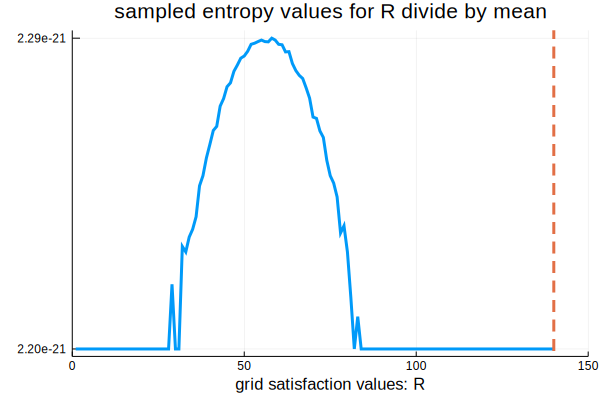

In [16]:
plt2 = plot(1:R_MAX,sampleOmegaR,xlim=(0,R_MAX+10),linewidth=3,title="sampled omega size for R",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)
savefig(plt2,"figs/sampledOmega.png")



function S_entropy_values_from_R(R)
    return k_b * log(sampleOmegaR[R])
       
end

entropyVals = [S_entropy_values_from_R(R) for R in 1:R_MAX]

println(entropyVals)
println(S_entropy_values_from_R(1),"---",S_entropy_values_from_R(round(Int,R_MAX/2)))

minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt4 = plot(1:R_MAX,entropyVals,
    yticks=([minimum(entropyVals),maximum(entropyVals)],[labelMin,labelMax]),
    xlim=(0,R_MAX+10),ylim=(minimum(entropyVals)*(1-(10^-3)),(1 + 10^-3)*maximum(entropyVals)),
    linewidth=3,title="sampled entropy values for R divide by mean",xlabel="grid satisfaction values: R")
vline!([R_MAX],line=(3,:dash),leg=false)

Any[70, 130, 134, 136, 137, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
Any[2.27325e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21, 2.20463e-21]
-6.861567762246314932948691185646473509371161853002098718725116186740865919153919e-23
2.29e-212.20e-21


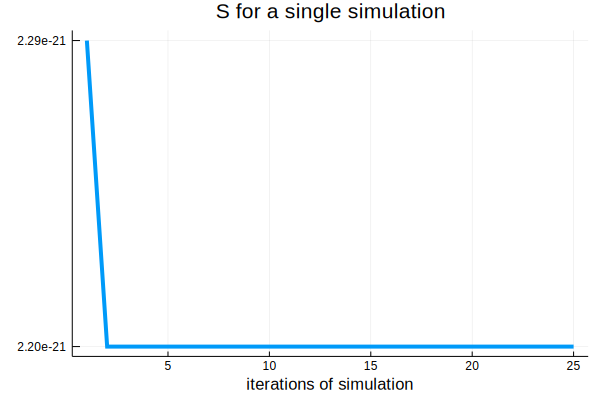

In [17]:
#plt3 = plot(1:R_MAX,entropyVals,xlim=(0,R_MAX+10),linewidth=3,title="sampled entropy values for R",xlabel="grid satisfaction values: R")
#vline!([R_MAX],line=(3,:dash),leg=false)
#savefig(plt3,"figs/sampledEntropy.png"
savefig(plt4,"figs/sampledEntropy.png")


#now do a single run trace with the entropy values and plot
traceR = Int[]
traceS = Int[]

newGrid = shuffle(empty_grid)
traceR = []
traceS = []
Rtmp = grid_satisfaction(newGrid)
append!(traceR,Rtmp)
append!(traceS,S_entropy_values_from_R(Rtmp))
for tt in 2:TT
    newGrid = move_cells_for_satisfaction(newGrid)
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
end
println(traceR)
println(traceS)

println( minimum(traceS) - maximum(traceS)   )


minStr = string(minimum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(entropyVals)) )
tmp2 = string(minimum(entropyVals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(entropyVals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(entropyVals)) )
tmp2 = string(maximum(entropyVals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt5 = plot(traceS,yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),ylims=(minimum(traceS)*(1-(10^-3)),(1 + 10^-3)*maximum(traceS)),
    linewidth=4,title="S for a single simulation",xlabel="iterations of simulation",leg=false)


In [18]:
savefig(plt5,"figs/entropySingleSimulation.png")



(25, 10)
2.29e-212.20e-21


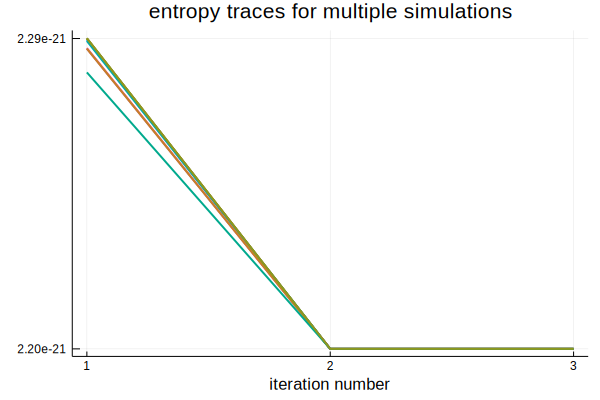

In [19]:


simulationSvals = zeros(TT,MM)
for mm in 1:MM
    traceR = Int[]
    traceS = Int[]

    newGrid = shuffle(empty_grid)
    traceR = []
    traceS = []
    Rtmp = grid_satisfaction(newGrid)
    append!(traceR,Rtmp)
    append!(traceS,S_entropy_values_from_R(Rtmp))
    for tt in 2:TT
        newGrid = move_cells_for_satisfaction(newGrid)
        Rtmp = grid_satisfaction(newGrid)
        append!(traceR,Rtmp)
        append!(traceS,S_entropy_values_from_R(Rtmp))
    end
    simulationSvals[:,mm] = traceS[:]

end

println(size(simulationSvals))
minimumS = minimum(simulationSvals)
maximumS = maximum(simulationSvals)



minStr = string(minimum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(minimum(simulationSvals)) )
tmp2 = string(minimum(simulationSvals))[tmp:end]
labelMin = string(minStr,tmp2)
maxStr = string(maximum(simulationSvals))[1:4] 
tmp = findfirst( isequal('e') , string(maximum(simulationSvals)) )
tmp2 = string(maximum(simulationSvals))[tmp:end]
labelMax = string(maxStr,tmp2)
println(labelMax,labelMin)

plt7 = plot(simulationSvals[1:3,1:end],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=2,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


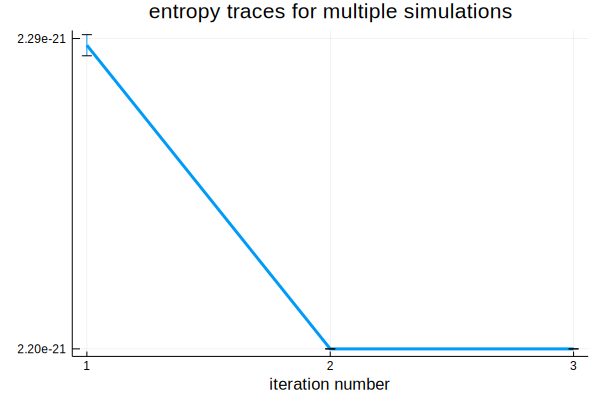

In [20]:
savefig(plt7,"figs/entropyMultipleSimulations.png")


plt8 = plot(mean(simulationSvals,dims=2)[1:3],
    yerr=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 



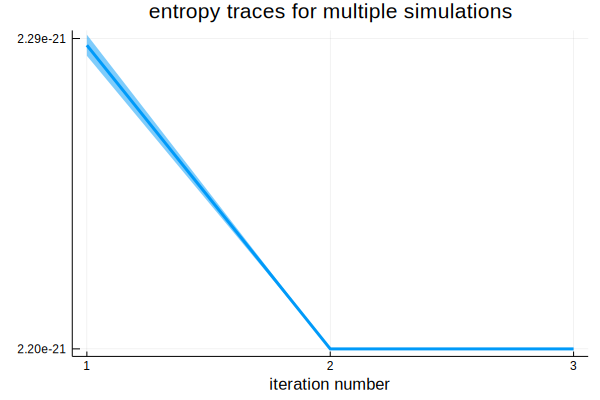

In [21]:
savefig(plt8,"figs/entropyMultipleSimulationsSpread.png")


plt9 = plot(mean(simulationSvals,dims=2)[1:3],
    ribbon=std(simulationSvals,dims=2)[1:3],
    yticks=([minimum(traceS),maximum(traceS)],[labelMin,labelMax]),
    ylims=(minimum(simulationSvals)*(1-(10^-3)),(1 + 10^-3)*maximum(simulationSvals)),
    xticks=1:3,
    linewidth=3,xlabel="iteration number",title="entropy traces for multiple simulations",leg=false)#,ylim=(0,R_MAX+10)) 


In [22]:
savefig(plt9,"figs/entropyMultipleSimulationsSpreadRibbon.png")




In [42]:
###############

#wealth distribution data taken from: https://raw.githubusercontent.com/jkeesh/which-percent/master/data.csv
# It is based on data from the US census as well as the Social Security Administration
csvWealth = CSV.File("wealthDistribution.csv",header=false)
dfWealth = DataFrame(csvWealth)
percs = dfWealth[:,4]
percsNew=[percs[i][1:end-1] for i in 1:length(percs)]
percsNewNew = [ parse(Float64,percsNew[i]) for i in 1:length(percs)]


function df2wealthArray(dfWealth)
    meansBracket = []
    for i in 1:size(dfWealth)[1]
        
        inds = findall(isequal(' '),dfWealth[i,1])
        
        money1 = dfWealth[i,1][1:inds[1]-1]
        money2 = dfWealth[i,1][inds[2]+1:end]
        
        
        
        if(i == size(dfWealth)[1])
            money2 = money1
        end
        
        money1 = replace(money1,","=>"")
        money2 = replace(money2,","=>"")
        money1 = parse(Float64,money1)
        money2 = parse(Float64,money2)
        
        #println(mean([money1,money2]))
        append!(meansBracket,mean([money1,money2]))
        
    end
    return meansBracket
end
wealthBrackets = df2wealthArray(dfWealth)
percsAndWealth = hcat(percsNewNew,wealthBrackets) 
println(percsAndWealth)
println(percsAndWealth[1,:])


Any[100.0 2500.0; 85.7293 7499.99; 76.9745 12500.0; 69.1804 17500.0; 61.9069 22500.0; 55.0045 27500.0; 48.561 32500.0; 42.5631 37500.0; 37.1403 42500.0; 32.3649 47500.0; 28.2287 52500.0; 24.6107 57500.0; 21.5469 62500.0; 18.891 67500.0; 16.632 72500.0; 14.6756 77500.0; 12.9786 82500.0; 11.5263 87500.0; 10.2775 92500.0; 9.1938 97500.0; 8.254 102500.0; 7.4264 107500.0; 6.7202 112500.0; 6.1026 117500.0; 5.5552 122500.0; 5.0663 127500.0; 4.6402 132500.0; 4.2636 137500.0; 3.9302 142500.0; 3.635 147500.0; 3.3701 152500.0; 3.127 157500.0; 2.915 162500.0; 2.7278 167500.0; 2.5601 172500.0; 2.4087 177500.0; 2.272 182500.0; 2.1452 187500.0; 2.032 192500.0; 1.9275 197500.0; 1.8301 225000.0; 1.1727 275000.0; 0.8155 325000.0; 0.6046 375000.0; 0.4656 425000.0; 0.37 475000.0; 0.3012 750000.0; 0.0825 1.25e6; 0.0411 1.75e6; 0.0258 2.25e6; 0.0182 2.75e6; 0.0138 3.25e6; 0.0108 3.75e6; 0.0087 4.25e6; 0.0072 4.75e6; 0.0061 7.5e6; 0.002 1.5e7; 0.0006 3.5e7; 0.0001 5.0e7]
Any[100.0, 2500.0]


In [23]:
#schelling said that the small changes in probability can have drastic effects. and that these
#preferencces can be so small that even the agents themselves the residents are not 
#aware of their biases because of the effects on the macrostate examining individuals
#may not be a viable solution. Therefore examining the macrostate and the change in the
#entropy would be a more sensitive and reslient approach. the minor amplificiations on
#the agent level can produce massive combinational changes on the macrostate.
#it also reacts quickly!

#the radial disperal at the start is benign, but afterwards the high wealth individuals
#create a block for the low to now enter like in physics for the satisfaction of new
#molecular bonds in how satisfied they will be. That is the same as 'gentrification'

#do the plots now with the LOG of the DIFFERENCE between the values so that the small changes appear covered in the shadow of the huge significant figures before it


#we get eg 1000 wealth samples, made a CDF and sample from that for the allocations and then the wealth on movement that here is initially random that gets radially distributed.
#how many random allocations of the financial units would it take to arrive at the distribution of the wealth indicators
#eg, we start out with wealth sampled from the CDF, we allocate them to the residents. they then move around randomly without homogeneity search
#we then do a set of random allocations of the funds to get a distribution for the variance of the wealth and the skew so that we can say that the macro state variable is the variance and skew


#later we do the model that has both the homogeneity and the financial indicators and get the macrostate trajectory

#question: we need to have the purchasing to be constrained so that they cannot move forever or that we can regulated it according to the size of the system.
#if tons of wealth is dropped it can go forever? or can we say that the wealth movement is a relative measure? the relative measure would be more robust but the constrained version
#should also work.

In [24]:
#now to find a model that respects an increasing entropy value trace
#now to do the financial part...


#when an agent moves into a new place, they subtract the averagej from themselves
#and distribute that radially amongst the surrounding people.

#what is the accumulated gaps....of the wealth on the local levels..! :)
#take the min and max due to corners, then we keep that difference, and take the accumulation of the total differences
#we simply compare that aggregate to the aggregates of the random initial samples...



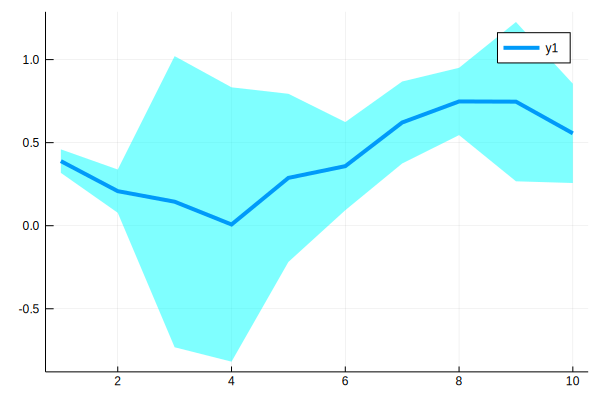

In [25]:
 plot(rand(10),ribbon=rand(10),fill=:cyan,linewidth=4)

In [26]:
function f1(x)
    x = x^2
    return x+x
end

f1 (generic function with 1 method)

In [27]:
x=3
println(f1(x))

18


$$\lambda + \beta$$
$$\frac{12}{4}$$

In [28]:
#old code


function grid_satisfactionOLD(start_grid) 
cell_satisfaction = []

    for row in 1:GRID_SIZE
        for col in 1:GRID_SIZE
            cell_surrounding = []
            if(!(row == 1 || row == GRID_SIZE || col == 1 || col == GRID_SIZE))#general inner body
                for ii in 0:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==GRID_SIZE))#bottom right corner
                for ii in 0:1
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==1))#top left corner
                for ii in 1:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && col==GRID_SIZE))#top right corner
                for ii in 1:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==GRID_SIZE && col==1))#bottom left corner
                for ii in 0:1
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if((row==1 && (col < GRID_SIZE && col > 1) ))#top edge
                for ii in 1:2
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)
                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end
            end
            if( (row > 1 && row < GRID_SIZE) && (col == 1) )#left edge
                for ii in 0:2
                    for jj in 1:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row > 1 && row < GRID_SIZE) && (col == GRID_SIZE) )#right edge
                for ii in 0:2
                    for jj in 0:1
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
            if( (row == GRID_SIZE) && (col > 1 && col < GRID_SIZE) )#bottom edge
                for ii in 0:1
                    for jj in 0:2
                        if(!(ii==1 && jj==1))
                            append!(cell_surrounding,start_grid[row-1+(ii),(col-1)+(jj)])
                        end

                    end
                end
                #println(cell_surrounding)

                if(start_grid[row,col] != 0)
                    homogeneous_count = length(findall(start_grid[row,col] .== cell_surrounding))
                    if(homogeneous_count >= THRESHOLD_EDGE)
                        append!(cell_satisfaction,1)
                    else
                        append!(cell_satisfaction,0)
                    end
                else
                    append!(cell_satisfaction,0)
                end

            end
        end
    end
#println(cell_satisfaction)
#println(size(cell_satisfaction))
#println(sum(cell_satisfaction))

    return sum(cell_satisfaction)
end

satisfiedOneGrid = grid_satisfactionOLD(start_grid)
println("random grid satisfactionOLD value=",satisfiedOneGrid)
R_MAX = grid_satisfactionOLD(set_grid)
println("set grid satisfactionOLD value=",R_MAX)

random grid satisfactionOLD value=80
set grid satisfactionOLD value=140
